In [1]:
import pandas as pd 
import json
import numpy as np

In [2]:
#Lecture des données
tunisian_stock_market = 'Tunisian-Stock-Market.json'
with open(tunisian_stock_market, 'r') as json_file:
    
    json_data = json.load(json_file)
TunisianStockMarket = pd.DataFrame(json_data)

In [3]:
#Choix d'une seule action(BNA dans notre cas)
TunisianStockMarket['Date'] = pd.to_datetime(TunisianStockMarket['Date'])
bna_data = TunisianStockMarket[TunisianStockMarket['Stock_name'] == 'BNA']

In [4]:
#Filtrage des colonnes non utile
columnsToExclude = ['Code_isin','Stock_name']
TunisianStockMarketFiltred = bna_data.drop(columns=columnsToExclude)
filtered_data = TunisianStockMarketFiltred[TunisianStockMarketFiltred['Date'].dt.year.isin([2020, 2021])]
print(TunisianStockMarketFiltred)

             Date  Adj_Close  Adj_low  Adj_High         Volume
62     2021-11-04      7.320    7.220     7.320    6137.930176
141    2021-11-03      7.320    7.100     7.320   34433.000000
220    2021-11-02      7.310    7.200     7.320   24964.289062
299    2021-11-01      7.320    7.200     7.340    5781.819824
378    2021-10-29      7.340    7.300     7.340    6610.660156
...           ...        ...      ...       ...            ...
198646 2011-01-07     11.305   11.210    11.320   52695.449219
198702 2011-01-06     11.283   11.173    11.393   43161.000000
198758 2011-01-05     11.349   10.989    11.349   86125.226562
198814 2011-01-04     11.129   10.952    11.129  105979.023438
198870 2011-01-03     11.173   10.952    11.298    1721.199951

[2689 rows x 5 columns]


In [5]:
#Function to make date format to datetime
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year , month , day = int(split[0]) , int(split[1]) , int(split[2])
    return datetime.datetime(year=year , month=month , day=day)

In [6]:
#TunisianStockMarketFiltred['Date'] = TunisianStockMarketFiltred['Date'].apply(str_to_datetime)
#TunisianStockMarketFiltred['Date']

In [7]:
TunisianStockMarketFiltred.index = TunisianStockMarketFiltred.pop('Date')
TunisianStockMarketFiltred

,Adj_Close,Adj_low,Adj_High,Volume
Date,,,,
2021-11-04,7.320,7.220,7.320,6137.930176
2021-11-03,7.320,7.100,7.320,34433.000000
2021-11-02,7.310,7.200,7.320,24964.289062
2021-11-01,7.320,7.200,7.340,5781.819824
2021-10-29,7.340,7.300,7.340,6610.660156
...,...,...,...,...
2011-01-07,11.305,11.210,11.320,52695.449219
2011-01-06,11.283,11.173,11.393,43161.000000
2011-01-05,11.349,10.989,11.349,86125.226562


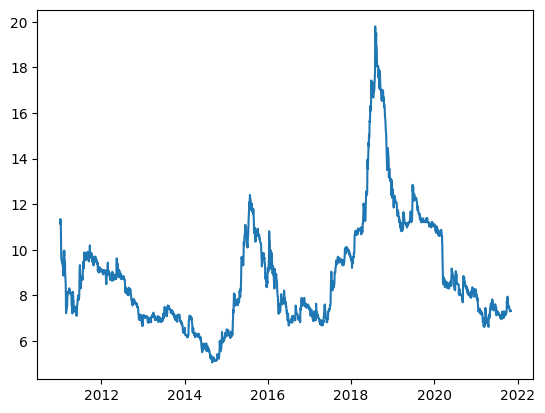

In [8]:
import matplotlib.pyplot as plt 

plt.plot(TunisianStockMarketFiltred.index , TunisianStockMarketFiltred['Adj_Close'])

In [9]:
#Create windowed data every 3 days
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Adj_Close'].shift(i)
    windowed_data['Target'] = data['Adj_Close']
    return windowed_data.dropna()


windowed_data = window_data(TunisianStockMarketFiltred, n = 3)
windowed_data.sort_index(inplace=True, ascending=True)
windowed_data

,Target-3,Target-2,Target-1,Target
Date,,,,
2011-01-03,11.283,11.349,11.129,11.173
2011-01-04,11.305,11.283,11.349,11.129
2011-01-05,11.232,11.305,11.283,11.349
2011-01-06,10.857,11.232,11.305,11.283
2011-01-07,10.372,10.857,11.232,11.305
...,...,...,...,...
2021-10-26,7.340,7.300,7.300,7.330
2021-10-27,7.320,7.340,7.300,7.300
2021-10-28,7.310,7.320,7.340,7.300


In [10]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = windowed_dataframe.index.values

  middle_matrix = df_as_np[:, 0:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_data)

dates.shape, X.shape, y.shape


((2686,), (2686, 3, 1), (2686,))

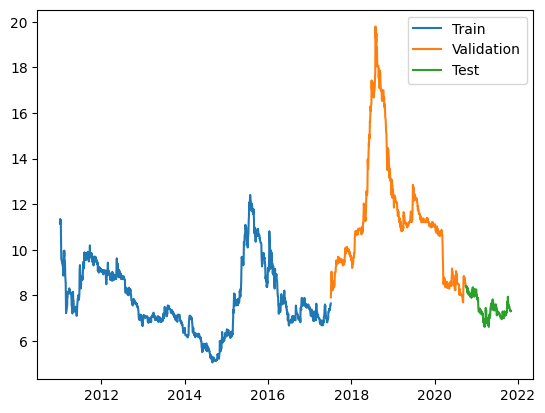

In [11]:
q_60 = int(len(dates) * .6)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_60], X[:q_60], y[:q_60]
dates_val, X_val, y_val = dates[q_60:q_90], X[q_60:q_90], y[q_60:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [12]:
from tensorflow.keras.models import Sequential #Sequential model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 
import distutils



model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(1)])

model.compile(loss='MSE' ,
               optimizer=Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])

model.fit(X_train, y_train , validation_data = (X_val , y_val) , epochs=100)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 51.0052 - mean_absolute_error: 6.8915 - val_loss: 13.4084 - val_mean_absolute_error: 2.8097
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.7726 - mean_absolute_error: 1.1127 - val_loss: 12.6147 - val_mean_absolute_error: 2.7316
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9818 - mean_absolute_error: 0.8091 - val_loss: 10.7516 - val_mean_absolute_error: 2.5123
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5808 - mean_absolute_error: 0.5951 - val_loss: 6.0738 - val_mean_absolute_error: 1.7268
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1738 - mean_absolute_error: 0.2981 - val_loss: 3.5714 - val_mean_absolute_error: 1.1412
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0567 - mean_absolute_error: 0.1581 - val_loss: 2.6910 - val_mean_absolute_error: 0.8889
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0389 - mean_absolute_error: 0.1366 - val

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


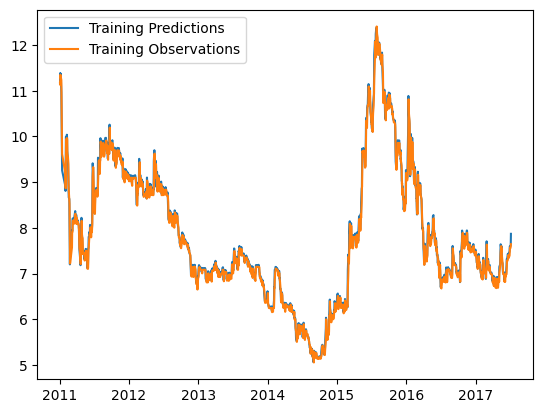

In [13]:
train_prediction = model.predict(X_train).flatten()

plt.plot(dates_train , train_prediction)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions' , 'Training Observations'])

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


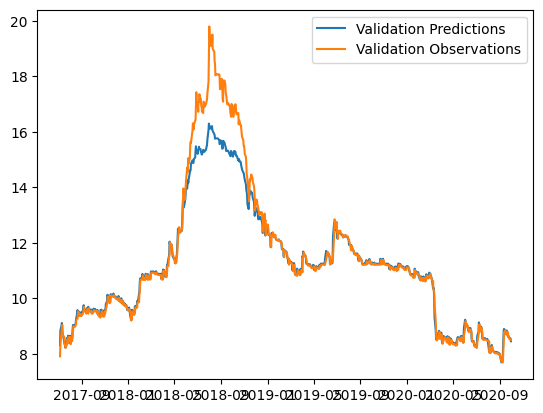

In [14]:
val_prediction = model.predict(X_val).flatten()

plt.plot(dates_val , val_prediction)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions' , 'Validation Observations'])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


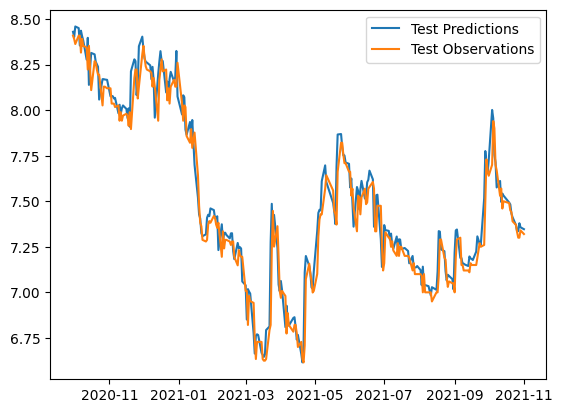

In [15]:
test_prediction = model.predict(X_test).flatten()

plt.plot(dates_test , test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions' , 'Test Observations'])

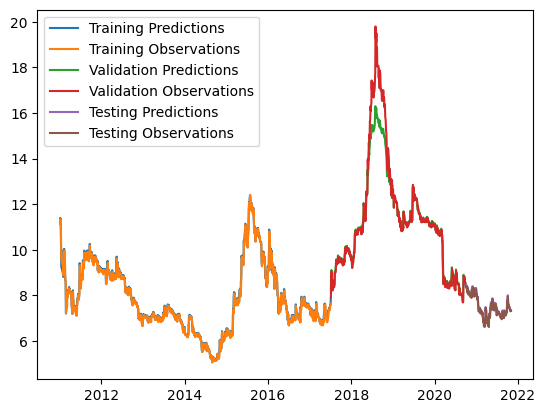

In [16]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [17]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

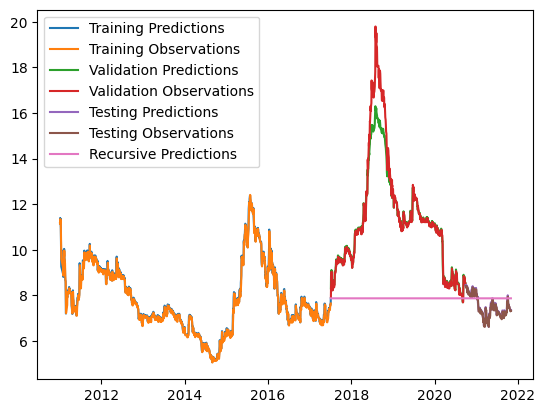

In [18]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])